# eIF3 PAR-CLIP analysis

- Purpose: To detect eIF3a/b/d/g PAR-CLIP cluster on LINE1
- iCLIP Reference: https://www.nature.com/articles/nature14267 (GSE65004)
- Samples: (eIF3a, b, d & g) X (3 replicates)
- Cell: 293T
- Adapter: TGGAATTCTCGGGTGCCAAGG (3'), NNNNNNNNGTAC (5' for rep1)

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-05-27.


In [2]:
home = '/casa/bsc/projects/__etc__/2020_eIF3_iCLIP/'
%cd $home

/casa/bsc/projects/__etc__/2020_eIF3_iCLIP


In [3]:
from __future__ import division
import sys; sys.path.append('/casa/bsc/notebooks/')
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/200527/


In [9]:
import pandas as pd
import numpy as np
import gzip
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

In [29]:
SAMPLES = [ 'eif3a_rep1', 'eif3b_rep1', 'eif3d_rep1', 'eif3g_rep1' ]

#### Experimental scheme

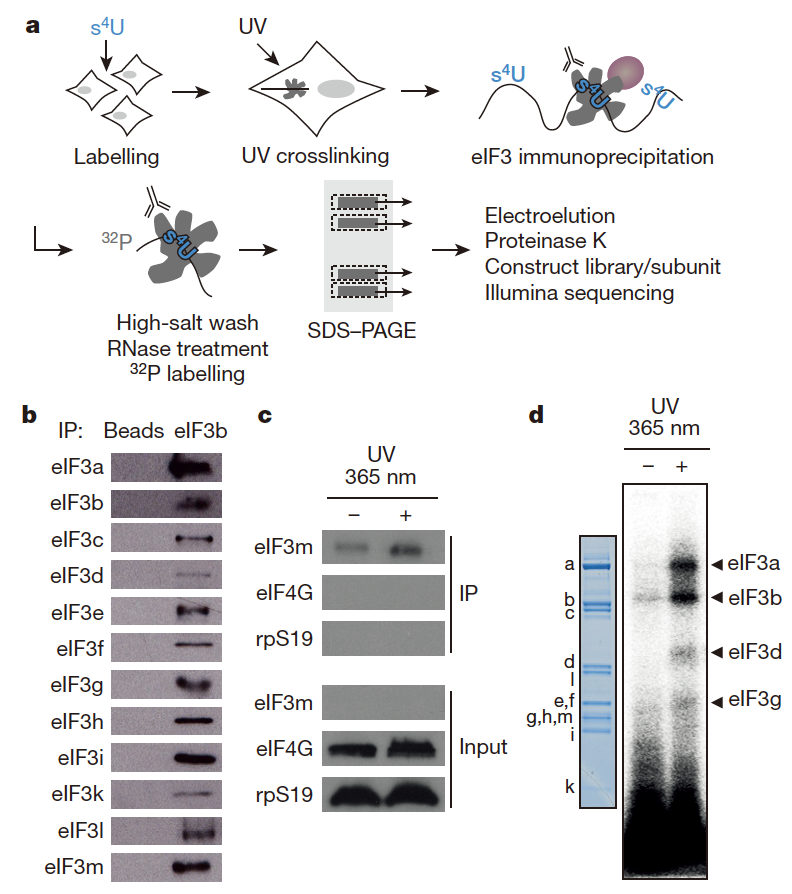

In [5]:
from IPython.display import Image
Image(filename='fig1a.png', width=500)

#### Library preparation
293T cells were treated with 4-thiouridine and protein-RNA complexes were crosslinked, and eIF3-RNA complexes were immunoprecipitated. Replicate 1 includes use of primer ID on the 5' end ("NNNNNNNNGUAC"). The 3' adapter used for all samples was: 5' rApp /TGGAATTCTCGGGTGCCAAGG/ 3ddC/

#### Positive control: BTG1 
https://www.ncbi.nlm.nih.gov/nuccore/NM_001731.3?report=fasta

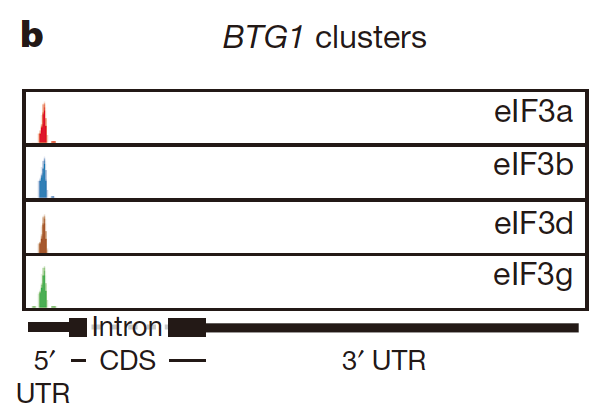

In [6]:
Image(filename='fig3b.png', width=300)

---
## Preprocessing results

In [9]:
def get_depth(filename, filetype):
    if filetype == 'fq':
        tmp = !zcat $filename | wc -l
        return int(tmp[0])//4
    elif filetype == 'fa':
        tmp = !zcat $filename | wc -l
        return int(tmp[0])//2
    elif filetype == 'sam':
        tmp = !zcat $filename | wc -l
        return int(tmp[0])
    else:
        tmp = !wc -l $filename 
        return int(tmp[0].split()[0])

In [11]:
rawdepths = {}
for sample in SAMPLES:
    rawfile = 'rawdata/%s.fastq.gz' % sample
    rawdepth = get_depth(rawfile, 'fq')
    rawdepths[sample] = rawdepth
    print sample, '%.2e' % rawdepth

eif3a_rep1 1.20e+08
eif3a_rep2 8.54e+07
eif3a_rep3 4.66e+07
eif3b_rep1 9.60e+07
eif3b_rep2 1.03e+08
eif3b_rep3 8.24e+07


In [13]:
qcdepths = {}
for sample in SAMPLES:
    qcfile = 'qc/%s.fa.gz' % sample
    qcdepth = get_depth(qcfile, 'fa')
    qcdepths[sample] = qcdepth
    print sample, '%.1f%%'%(qcdepth/rawdepths[sample]*100)

eif3a_rep1 92.0%
eif3a_rep2 91.5%
eif3a_rep3 94.9%
eif3b_rep1 88.8%
eif3b_rep2 93.0%
eif3b_rep3 93.1%


In [14]:
coldepths = {}
for sample in SAMPLES:
    colfile = 'coll/%s.fa.gz' % sample
    coldepth = get_depth(colfile, 'fa')
    coldepths[sample] = coldepth
    print sample, '%.1f%%'%(coldepth/rawdepths[sample]*100)

eif3a_rep1 15.7%
eif3a_rep2 5.7%
eif3a_rep3 10.1%
eif3b_rep1 33.4%
eif3b_rep2 6.7%
eif3b_rep3 8.1%


In [15]:
cutadepths = {}
for sample in SAMPLES:
    cutafile = 'data/%s.fa.gz' % sample
    cutadepth = get_depth(cutafile, 'fa')
    cutadepths[sample] = cutadepth
    print sample, '%.1f%%'%(cutadepth/rawdepths[sample]*100)

eif3a_rep1 10.7%
eif3a_rep2 5.4%
eif3a_rep3 7.1%
eif3b_rep1 25.0%
eif3b_rep2 5.5%
eif3b_rep3 5.1%


In [7]:
from alignutil import cigar_to_len

In [30]:
cntd = {}
for sample in SAMPLES:
    samfile = 'alignments/%s_10.txt.gz' % sample
    tbl = pd.read_table(gzip.open(samfile, 'rb'), sep=' ',
                        names=['gene', 'start', 'cigar', '.'])
    tbl['len'] = tbl['cigar'].apply(cigar_to_len)
    tbl['end'] = tbl['start'] + tbl['len']
    cnttbl = tbl.groupby(['gene', 'start', 'end']).size()
    cntd[sample] = cnttbl

In [31]:
clvtbl = pd.DataFrame(cntd).fillna(0).astype(int)

In [32]:
l1 = clvtbl.loc['L1Hs'].reset_index()
l1.head()

,start,end,eif3a_rep1,eif3b_rep1,eif3d_rep1,eif3g_rep1
0,1,11,0,0,2,0
1,1,13,0,1,1,0
2,2,12,0,1,0,1
3,2,13,2,2,3,5
4,2,14,0,0,0,1


In [33]:
u5s = 906
orf1s,orf1e = 907,1923
orf2s,orf2e = 1987,5814
u3s = 5815

In [34]:
utr5 = l1[l1['end']<=u5s]
orf1 = l1[(l1['start']>=orf1s)&(l1['end']<orf1e)]
orf2 = l1[(l1['start']>=orf2s)&(l1['end']<orf2e)]
utr3 = l1[l1['start']>=u3s]

In [35]:
utr5l = 906
orf1l = (orf1e-orf1s)
orf2l = (orf2e-orf2s)
utr3l = (6019-u3s)
print orf1l, orf2l, utr3l

1016 3827 204


In [36]:
utr5.sum()/utr5l

start         806.020971
end           826.907285
eif3a_rep1      1.743929
eif3b_rep1      8.488962
eif3d_rep1      9.422737
eif3g_rep1      7.994481
dtype: float64

In [37]:
orf1.sum()/orf1l

start         1782.469488
end           1796.771654
eif3a_rep1       0.898622
eif3b_rep1       6.411417
eif3d_rep1       4.202756
eif3g_rep1       3.875000
dtype: float64

In [38]:
orf2.sum()/orf2l

start         4405.177424
end           4417.906454
eif3a_rep1       0.749412
eif3b_rep1       4.709694
eif3d_rep1       3.637575
eif3g_rep1       3.400575
dtype: float64

In [39]:
utr3.sum()/utr3l

start         8588.843137
end           8605.098039
eif3a_rep1       1.127451
eif3b_rep1       4.759804
eif3d_rep1       5.294118
eif3g_rep1       4.289216
dtype: float64

In [35]:
from matplotlib import pyplot as plt
%matplotlib inline

In [40]:
datab = [ 8.488962, 6.411417, 4.709694, 4.759804 ]
dataa = [ 1.743929, 0.898622, 0.749412, 1.127451 ]
datad = [ 9.422737, 4.202756, 3.637575, 5.294118 ]
datag = [ 7.994481, 3.875000, 3.400575, 4.289216 ]

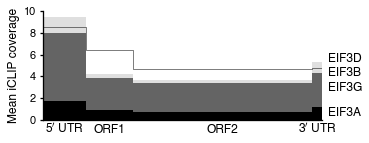

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(5,2))
xs = [0,1,1+orf1l/utr5l,1+(orf1l+orf2l)/utr5l,1+(orf1l+orf2l+utr3l)/utr5l]
ws = np.array(xs[1:])-np.array(xs[:-1])
#ax.bar(xs[:-1],datab, width=ws, align='edge', color='#ababab', alpha=.3)
ax.bar(xs[:-1],datad, width=ws, align='edge', color='#969696', alpha=.3)
ax.bar(xs[:-1],datag, width=ws, align='edge', color='#646464', alpha=1)
ax.bar(xs[:-1],dataa, width=ws, align='edge', color='black', alpha=1)
ax.plot([xs[0],xs[1],xs[1],xs[2],xs[2],xs[3],xs[3],xs[4]],
        [datab[0],datab[0],datab[1],datab[1],datab[2],datab[2],datab[3],datab[3]], 'k-',lw=.5)

ax.set_xlim(0,xs[-1])
ax.set_xticks(xs)
ax.set_xticklabels([])
ax.set_ylabel('Mean iCLIP coverage', fontsize=12)
ax.set_yticks(range(0,11,2))
ax.tick_params(bottom='off')
labels = [ '5$^\prime$ UTR', 'ORF1', 'ORF2', '3$^\prime$ UTR' ]
for x,l in zip((np.array(xs[1:])/2+np.array(xs[:-1])/2), labels):
    ax.text(x, -1.2, l, fontsize=12, ha='center')
ax.text(6.7, 4, 'EIF3B', fontsize=12)
ax.text(6.7, 2.7, 'EIF3G', fontsize=12)
ax.text(6.7, 5.3, 'EIF3D', fontsize=12)
ax.text(6.7, .4, 'EIF3A', fontsize=12)
fig.savefig(resultpath + '200526_coverage_l1_ver3.pdf')

In [62]:
l1cov = l1[l1['start']<=906].set_index(['start','end'])
print len(l1cov)
l1cov.head(3)

1663


eif3a_rep1  eif3b_rep1  eif3d_rep1  eif3g_rep1
start end                                                
1     11            0           0           2           0
      13            0           1           1           0
2     12            0           1           0           1

In [67]:
covers = np.array([0]*906)
for (s,e), row in l1cov.iterrows():
    cnt = row['eif3g_rep1']
    covers[s-1:min(e,906)] = covers[s-1:min(e,906)]+cnt

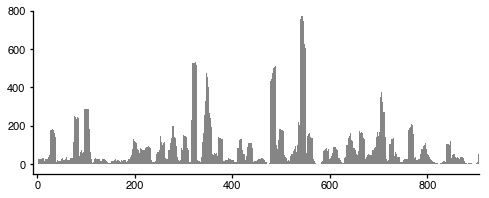

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.bar(range(906), covers, color='#858585', width=1)
ax.set_xlim(-10, 906)
ax.set_ylim(-50, 800)
fig.savefig(resultpath + '200527_coverage_eif3g_rep1.pdf')